In [1]:
import pandas as pd
import numpy as np

from medangel.data import preprocessing
from medangel.models import model_builder
from medangel.features import feature_creation

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import matthews_corrcoef
from sklearn.feature_selection import RFE

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.transformers import FeatureSelector

from lightgbm import LGBMClassifier

import re

import time

from tqdm import tqdm

C:\Python\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = preprocessing.load_relevant_data()

In [76]:
df.device_id.value_counts()

48790    85763
49486    76680
49589    62660
49446    58302
31948    49824
52049    44654
52148    43015
49444    29351
49465    16718
52040    10002
59497     6461
59396     3267
59519     2212
Name: device_id, dtype: int64

In [3]:
df

doy_id  temperature            datetime  device_id
0       31948:2019:13         20.3 2019-01-13 04:59:02      31948
1       31948:2019:13         20.3 2019-01-13 05:02:01      31948
2       31948:2019:13         20.3 2019-01-13 05:05:00      31948
3       31948:2019:13         20.3 2019-01-13 05:07:59      31948
4       31948:2019:13         20.3 2019-01-13 05:10:58      31948
...               ...          ...                 ...        ...
515934  31948:2019:13         20.4 2019-01-13 04:44:07      31948
515935  31948:2019:13         20.4 2019-01-13 04:47:06      31948
515936  31948:2019:13         20.3 2019-01-13 04:50:05      31948
515937  31948:2019:13         20.3 2019-01-13 04:53:04      31948
515938  31948:2019:13         20.3 2019-01-13 04:56:03      31948

[497434 rows x 4 columns]

In [4]:
df = df.drop(index = df.loc[df.device_id.isin([49103,47683])].index)

In [5]:
df

doy_id  temperature            datetime  device_id
0       31948:2019:13         20.3 2019-01-13 04:59:02      31948
1       31948:2019:13         20.3 2019-01-13 05:02:01      31948
2       31948:2019:13         20.3 2019-01-13 05:05:00      31948
3       31948:2019:13         20.3 2019-01-13 05:07:59      31948
4       31948:2019:13         20.3 2019-01-13 05:10:58      31948
...               ...          ...                 ...        ...
515934  31948:2019:13         20.4 2019-01-13 04:44:07      31948
515935  31948:2019:13         20.4 2019-01-13 04:47:06      31948
515936  31948:2019:13         20.3 2019-01-13 04:50:05      31948
515937  31948:2019:13         20.3 2019-01-13 04:53:04      31948
515938  31948:2019:13         20.3 2019-01-13 04:56:03      31948

[488909 rows x 4 columns]

In [6]:
df.hist(column='temperature')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B9F195C208>]],
      dtype=object)

In [7]:
# number of days
total_days = 497434 * 179 / 60 / 60 /24

In [8]:
#number of readings conversion to days
conversion = 179 / 60 / 60 /24

In [9]:
df[df.temperature < 2].hist(column='temperature')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B98ADC82C8>]],
      dtype=object)

In [10]:
days_bel_2 = df[df.temperature < 2].shape[0] * conversion

In [11]:
days_bel_2 / total_days * 100

3.175295617106993

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B989F9FC08>]],
      dtype=object)

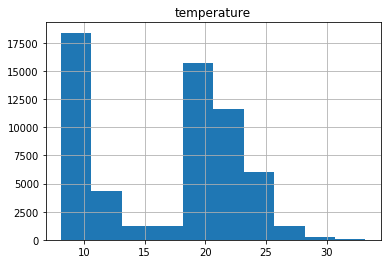

In [12]:
df[df.temperature > 8].hist(column='temperature')

In [13]:
days_ab_8 = df[df.temperature > 8].shape[0] * conversion
days_ab_8 / total_days * 100

12.071149137372998

In [14]:
days_out_of_range = days_ab_8 + days_bel_2
days_out_of_range/ total_days * 100

15.24644475447999

In [15]:
len(df.device_id.unique())

13

In [16]:
total_days

1030.5634953703704

In [17]:
days_bel_0 = df[df.temperature <= 0].shape[0] * conversion

In [18]:
days_bel_0 / total_days * 100

0.6382756305359103

In [3]:
features,y = preprocessing.load_feature_data()
features

temperature__variance_larger_than_standard_deviation  \
59497 99                                                  1.0      
      100                                                 1.0      
      101                                                 1.0      
      102                                                 1.0      
      103                                                 1.0      
...                                                       ...      
59519 2107                                                0.0      
      2108                                                0.0      
      2109                                                0.0      
      2110                                                0.0      
      2111                                                0.0      

            temperature__has_duplicate_max  temperature__has_duplicate_min  \
59497 99                               0.0                             0.0   
      100                              0.0                             0.0   
      101                              0.0                             0.0   
      102                              0.0                             0.0   
      103                              0.0                             0.0   
...                                    ...                             ...   
59519 2107                             1.0                             1.0   
      2108                             1.0                             1.0   
      2109                             1.0                             1.0   
      2110                             1.0                             0.0   
      2111                             1.0                             0.0   

            temperature__has_duplicate  temperature__sum_values  \
59497 99                           1.0                    548.0   
      100                          1.0                    536.5   
      101                          1.0                    529.8   
      102                          1.0                    526.4   
      103                          1.0                    524.9   
...                                ...                      ...   
59519 2107                         1.0                    175.7   
      2108                         1.0                    175.3   
      2109                         1.0                    174.9   
      2110                         1.0                    174.4   
      2111                         1.0                    174.0   

            temperature__abs_energy  temperature__mean_abs_change  \
59497 99                    3750.48                      0.270707   
      100                   3436.53                      0.224242   
      101                   3284.44                      0.191919   
      102                   3218.48                      0.173737   
      103                   3191.93                      0.167677   
...                             ...                           ...   
59519 2107                   310.69                      0.004040   
      2108                   309.25                      0.004040   
      2109                   307.81                      0.004040   
      2110                   306.06                      0.005051   
      2111                   304.62                      0.006061   

            temperature__mean_change  \
59497 99                   -0.117172   
      100                  -0.068687   
      101                  -0.034343   
      102                  -0.016162   
      103                  -0.008081   
...                              ...   
59519 2107                 -0.004040   
      2108                 -0.004040   
      2109                 -0.004040   
      2110                 -0.005051   
      2111                 -0.004040   

            temperature__mean_second_derivative_central  temperature__median  \
59497 99                                       0.024490        

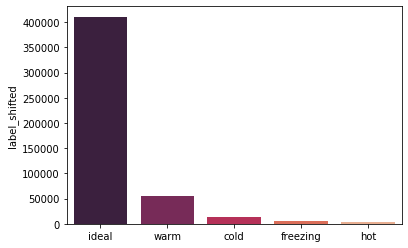

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.barplot(x=y.label_shifted.value_counts().index,y=y.label_shifted.value_counts(), palette="rocket")


In [21]:
df_count = y.label_shifted.value_counts().sort_values()

In [22]:
pd.DataFrame(df_count).T.plot.bar(stacked=True)

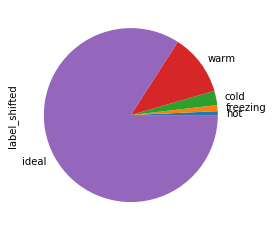

In [23]:
df_count.plot.pie()

In [24]:
df_model_comparison = pd.read_hdf(r'C:\Users\AliHa\Desktop\Masters Project\medangel\data\preprocessed\prediction_interval_comparison_data.h5',key="df")

[Text(0, 0, 'gpu'), Text(0, 0, 'no_gpu'), Text(0, 0, 'random_forest')]

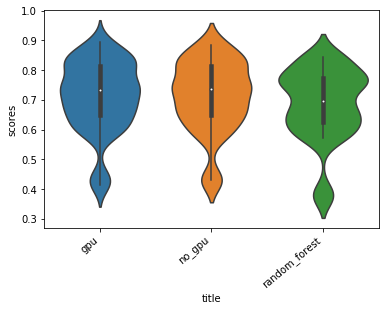

In [25]:
ax = sns.violinplot(x="title", y="scores", data=df_model_comparison)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

In [26]:
figdir = r'C:\Users\AliHa\Desktop\Masters Project\medangel\reports\figures'

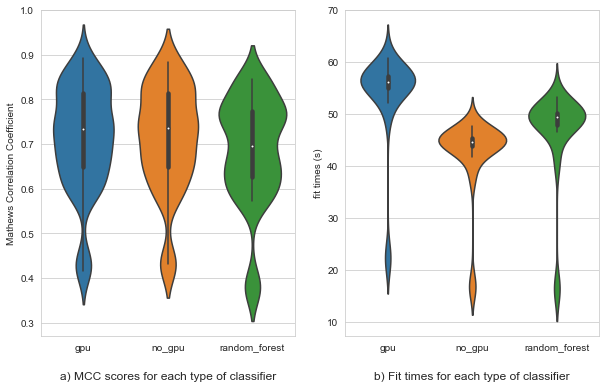

In [27]:
#change axis labels
sns.set_style("whitegrid")
fig, (ax1,ax2) =plt.subplots(nrows=1,ncols=2,figsize=(10,6))
ax1 = sns.violinplot(x="title", y="scores", data=df_model_comparison,ax=ax1)
ax1.set_title("a) MCC scores for each type of classifier",y = -0.15)
ax1.set_xlabel("")
ax1.set_ylabel("Mathews Correlation Coefficient")

#ax[0].set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax2 = sns.violinplot(x="title", y="fit_times", data=df_model_comparison,ax=ax2)
#ax[1].set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax2.set_ylabel("fit times (s)")
ax2.set_title("b) Fit times for each type of classifier",y = -0.15)
ax2.set_xlabel("")
fig.savefig(figdir + r'\classifier_experiment.pdf')

In [30]:
classifier__num_leaves = 80
classifier__n_estimators = 250
classifier__max_depth = 7
classifier__boosting_type = 'goss'
augmenter__fdr_level = 0.03


lgbm = Pipeline([
    ('sampler',RandomUnderSampler(random_state=42)),
    ('augmenter',FeatureSelector(fdr_level=augmenter__fdr_level,n_jobs=5)),
    ('classifier',LGBMClassifier(random_state=42,n_jobs=5,device_type = 'gpu',max_bin = 64,num_leaves=classifier__num_leaves,
    n_estimators=classifier__n_estimators,max_depth=classifier__max_depth,boosting_type=classifier__boosting_type,random_seed=42)),
])

y_temp = y.loc[y.index.isin(features.index)]
features = features.loc[y_temp.index]
x_array = np.array(features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)))
y_array = np.array(y_temp["label_shifted"])

lgbm.fit(x_array,y_array)

relevant_feature_names = features.iloc[:,lgbm.named_steps["augmenter"].relevant_features].columns

relevant_feature_lgbm_importance = lgbm["classifier"].feature_importances_

dict_relevant_features = {"feature": relevant_feature_names,
                         "lgbm_importance":relevant_feature_lgbm_importance}

df_relevant_features = pd.DataFrame(dict_relevant_features)

[LightGBM] [Warning] seed is set with random_seed=42, random_state=42 will be ignored. Current value: seed=42


In [31]:
sorted_rel = df_relevant_features.sort_values(by = ["lgbm_importance"],ascending = False)

In [32]:
sorted_rel.head(10)

feature  lgbm_importance
66                                temperature__minimum              896
57                                temperature__maximum              583
237  temperature__energy_ratio_by_chunks__num_segme...              553
80                        temperature__quantile__q_0.1              524
69                        temperature__quantile__q_0.9              405
77                    temperature__benford_correlation              402
489        temperature__ar_coefficient__coeff_10__k_10              389
181           temperature__spkt_welch_density__coeff_8              378
81                        temperature__quantile__q_0.2              362
204       temperature__approximate_entropy__m_2__r_0.1              356

In [33]:
column = sorted_rel.feature.values[0]

temp = features[column].quantile(0)
row = features[features.temperature__minimum == temp]

In [34]:
row

temperature__variance_larger_than_standard_deviation  \
49444 25051                                                1.0      
      25052                                                1.0      
      25053                                                1.0      
      25054                                                1.0      
      25055                                                1.0      
...                                                        ...      
      25147                                                1.0      
      25148                                                1.0      
      25149                                                1.0      
      25150                                                1.0      
      25151                                                1.0      

             temperature__has_duplicate_max  temperature__has_duplicate_min  \
49444 25051                             1.0                             0.0   
      25052                             1.0                             1.0   
      25053                             1.0                             1.0   
      25054                             1.0                             1.0   
      25055                             1.0                             1.0   
...                                     ...                             ...   
      25147                             1.0                             1.0   
      25148                             1.0                             1.0   
      25149                             1.0                             1.0   
      25150                             1.0                             1.0   
      25151                             1.0                             0.0   

             temperature__has_duplicate  temperature__sum_values  \
49444 25051                         1.0                   -192.0   
      25052                         1.0                   -199.2   
      25053                         1.0                   -206.5   
      25054                         1.0                   -213.7   
      25055                         1.0                   -220.6   
...                                 ...                      ...   
      25147                         1.0                    -93.0   
      25148                         1.0                    -87.0   
      25149                         1.0                    -80.8   
      25150                         1.0                    -74.4   
      25151                         1.0                    -67.8   

             temperature__abs_energy  temperature__mean_abs_change  \
49444 25051                  1594.16                      0.125253   
      25052                  1622.96                      0.123232   
      25053                  1649.97                      0.123232   
      25054                  1674.45                      0.124242   
      25055                  1694.46                      0.127273   
...                              ...                           ...   
      25147                   997.78                      0.231313   
      25148                   967.78                      0.234343   
      25149                   938.02                      0.236364   
      25150                   908.58                      0.237374   
      25151                   878.22                      0.238384   

             temperature__mean_change  \
49444 25051                 -0.072727   
      25052                 -0.074747   
      25053                 -0.074747   
      25054                 -0.073737   
      25055                 -0.070707   
...                               ...   
      25147                  0.057576   
      25148                  0.060606   
      25149                  0.062626   
      25150                  0.065657   
      25151                  0.066667   

             temperature__mean_second_derivative_central  temperature__median  \
494

In [12]:
devices = preprocessing.load_device_ids()
directory = r'C:\Users\AliHa\Desktop\Masters Project\medangel\data\preprocessed\rolling_data_device_'
df_rolled = pd.DataFrame()
for device in devices:
    temp_directory = directory + str(device) + '.h5'
    df_rolled = df_rolled.append(pd.read_hdf(temp_directory, key="df"))

In [36]:
row.index[0]

(49444, 25051)

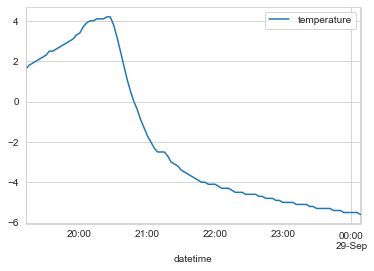

In [37]:
df_rolled[df_rolled.id == row.index[0]].plot(x="datetime",y="temperature")

In [4]:
def plot_quantile(column):
    features["label"] = y.label_shifted
    q03 = features[column].quantile(0.1)
    q07 = features[column].quantile(0.9)
    med = features[column].median()
    title03 = "b) 10th Percentile = " + "{:.2f}".format(q03)
    title07 = "c) 90th Percentile = " + "{:.2f}".format(q07)
    titlemed = "b) Median = " + "{:.2f}".format(med)
    rows03 = features.iloc[(features[column]-q03).abs().argsort()[:2]]
    rows07 = features.iloc[(features[column]-q07).abs().argsort()[:2]]
    rowsmed = features.iloc[(features[column]-med).abs().argsort()[:2]]
    df03 = df_rolled[df_rolled.id == rows03.index[1]]
    df07 = df_rolled[df_rolled.id == rows07.index[0]]
    dfmed = df_rolled[df_rolled.id == rowsmed.index[0]]
    sns.set_style("whitegrid")
    fig, (ax1,ax2,ax3) =plt.subplots(nrows=3,ncols=1,figsize=(8,12),gridspec_kw={'height_ratios': [2, 1, 1]})
    ax1 = sns.violinplot(x="label",y=column, data = features, ax=ax1,order=["freezing","cold","ideal","warm","hot"])
    ax1.set_ylabel('')
    #ax2.set_xticklabels(ax.get_xticklabels(), rotation=25, ha="right")
    #ax1.set_title(titlemed,fontsize = 15)
    #ax1.set_xlabel("Date and Time", fontsize = 10)
    #ax1.set_ylabel("Temperature C", fontsize = 10)
    ax2 = sns.lineplot(x="datetime", y="temperature", data=df03,ax=ax2)
    #ax1.set_xticklabels(ax.get_xticklabels(), rotation=25, ha="right")
    ax2.set_xlabel("Date and Time", fontsize = 13)
    ax2.set_ylabel("Temperature C", fontsize = 13)
    ax2.set_title(title03,fontsize = 15)
    ax3 = sns.lineplot(x="datetime", y="temperature", data=df07,ax=ax3)
    #ax2.set_xticklabels(ax.get_xticklabels(), rotation=25, ha="right")
    ax3.set_title(title07,fontsize = 15)
    ax3.set_xlabel("Date and Time", fontsize = 13)
    ax3.set_ylabel("Temperature C", fontsize = 13)
    fig.tight_layout(pad=2.0)
    return fig,ax1,ax2,ax3

(<Figure size 720x1296 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a6981e1d08>)

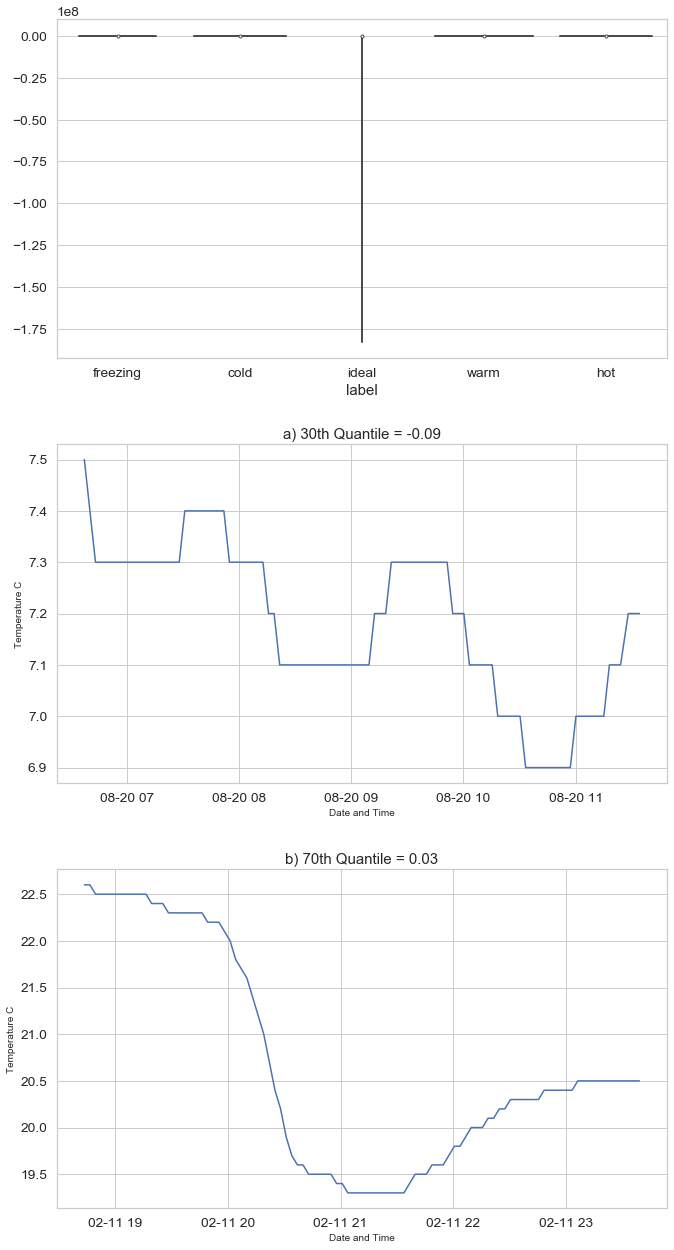

In [104]:
plot_quantile("temperature__ar_coefficient__coeff_10__k_10")

In [105]:
df_model_comparison

title  test_device    scores  fit_times  pred_times
0              gpu        31948  0.890389  57.382281    1.563340
1           no_gpu        31948  0.883733  45.907710    1.472328
2    random_forest        31948  0.844949  47.978388    0.480107
3              gpu        48790  0.846216  54.084455    2.326519
4           no_gpu        48790  0.845239  44.896846    2.318517
..             ...          ...       ...        ...         ...
970         no_gpu        59497  0.735678  40.483547    0.177038
971  random_forest        59497  0.748690  41.106622    0.138627
972            gpu        59519  0.755912  60.068523    0.086020
973         no_gpu        59519  0.753504  46.738287    0.054012
974  random_forest        59519  0.773700  51.128092    0.119689

[975 rows x 5 columns]

In [71]:
groupedvalues=df_model_comparison[df_model_comparison.title == "no_gpu"].groupby('test_device').mean().reset_index()


In [72]:
dfrandom = df_model_comparison[df_model_comparison.title == "no_gpu"]
dfrandom[dfrandom.test_device == 31948].mean()

C:\Python\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


test_device    31948.000000
scores             0.883733
fit_times         44.475830
pred_times         1.453044
dtype: float64

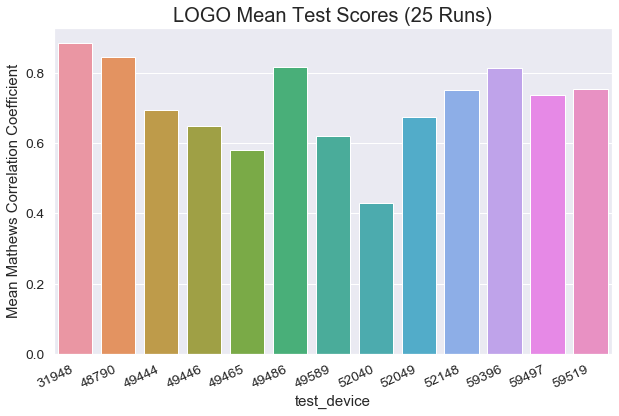

In [73]:
sns.set_style("whitegrid")
sns.set(font_scale=1.25)
fig, ax1 =plt.subplots(nrows = 1,figsize=(10,6))
ax1 = sns.barplot(x="test_device", y="scores", data=df_model_comparison[df_model_comparison.title == "no_gpu"],ax=ax1)
ax1.set_title("LOGO Mean Test Scores (25 Runs)",fontsize=20)
ax1.set_ylabel("Mean Mathews Correlation Coefficient")
#for index, row in groupedvalues.iterrows():
#    ax1.text(row.test_device,row.scores, round(row.scores,2), color='black', ha="center")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=25, ha="right")
fig.savefig(r'C:\Users\AliHa\Desktop\Masters Project\medangel\reports\figures\LOGO_mean_test_scores.pdf')

In [74]:
nogpudata = df_model_comparison[df_model_comparison.title == "no_gpu"]
nogpudata[nogpudata.test_device == 52040].scores.mean()

0.4306476975074894

In [75]:
nogpudata.scores.mean()

0.7116235999459083

In [110]:
sorted_rel.feature.values[:10]

array(['temperature__minimum', 'temperature__maximum',
       'temperature__energy_ratio_by_chunks__num_segments_10__segment_focus_9',
       'temperature__quantile__q_0.1', 'temperature__benford_correlation',
       'temperature__quantile__q_0.9',
       'temperature__ar_coefficient__coeff_10__k_10',
       'temperature__quantile__q_0.2',
       'temperature__approximate_entropy__m_2__r_0.1',
       'temperature__spkt_welch_density__coeff_8'], dtype=object)

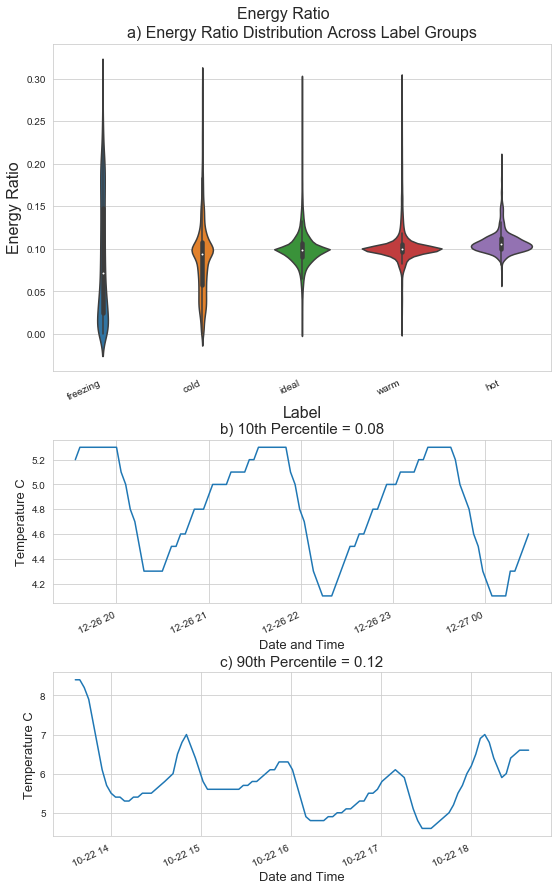

In [62]:
fig,ax1,ax2,ax3= plot_quantile("temperature__energy_ratio_by_chunks__num_segments_10__segment_focus_9")
ax1.set_title("a) Energy Ratio Distribution Across Label Groups",fontsize=16)
#ax2.set_title("b) Energy Ratio by Chunks 30th Quantile")
#ax3.set_title("c) Energy Ratio by Chunks 70th Quantile")
ax1.set_ylabel("Energy Ratio",fontsize=16)
ax1.set_xlabel("Label", fontsize=16,y=0.01)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=25, ha="right")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=25, ha="right")
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=25, ha="right")
fig.suptitle("Energy Ratio", y=1.02, fontsize=16)
fig.savefig(figdir + r'\energy_ratio_by_chunks_num_segments_10_focus_9_v2.pdf')

In [112]:
sorted_rel.lgbm_importance.values[:10]

array([902, 545, 537, 494, 417, 378, 371, 365, 352, 351])

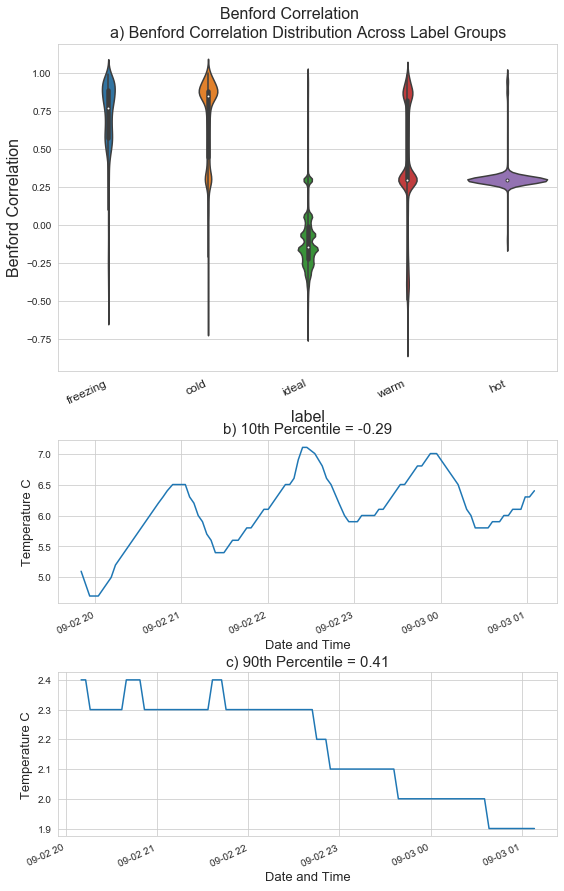

In [67]:
fig,ax1,ax2,ax3 = plot_quantile("temperature__benford_correlation")
ax1.set_title("a) Benford Correlation Distribution Across Label Groups", fontsize=16)
#ax1.set_title("a) Benford Correlation - 30th Quantile")
#ax2.set_title("b) Benford Correlation - 70th Quantile")
ax1.set_ylabel("Benford Correlation", fontsize=16)
ax1.set_xlabel("label",fontsize=16, y =0.02)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=25, ha="right", fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=25, ha="right")
ax3.set_xticklabels(ax2.get_xticklabels(), rotation=25, ha="right")
fig.suptitle("Benford Correlation", y=1.02, fontsize=16)
fig.savefig(figdir + r'\benford_correlation_v2.pdf')

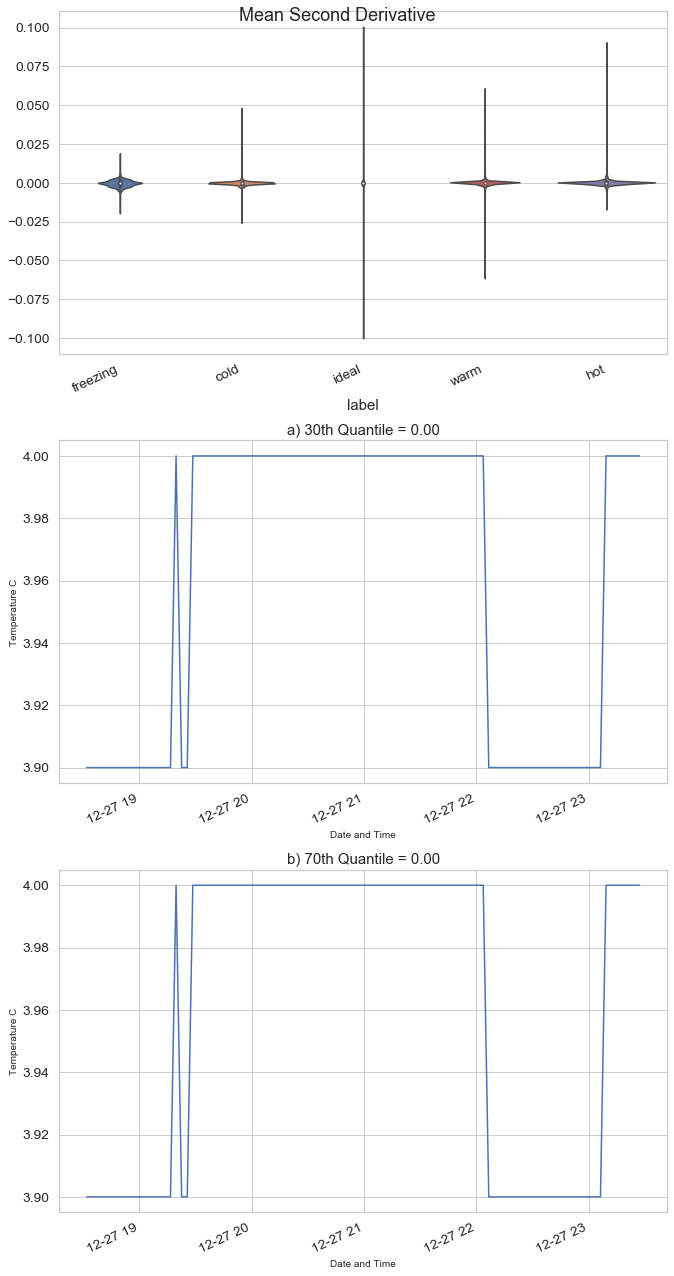

In [114]:
fig,ax1,ax2,ax3 = plot_quantile("temperature__mean_second_derivative_central")
#ax1.set_title("a) Mean Second Derivative Central - 30th Quantile")
#ax2.set_title("b) Mean Second Derivative Central - 70th Quantile")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=25, ha="right")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=25, ha="right")
ax3.set_xticklabels(ax2.get_xticklabels(), rotation=25, ha="right")
fig.suptitle("Mean Second Derivative")
fig.savefig(figdir + r'\mean_second_derivative_central_v2.png')

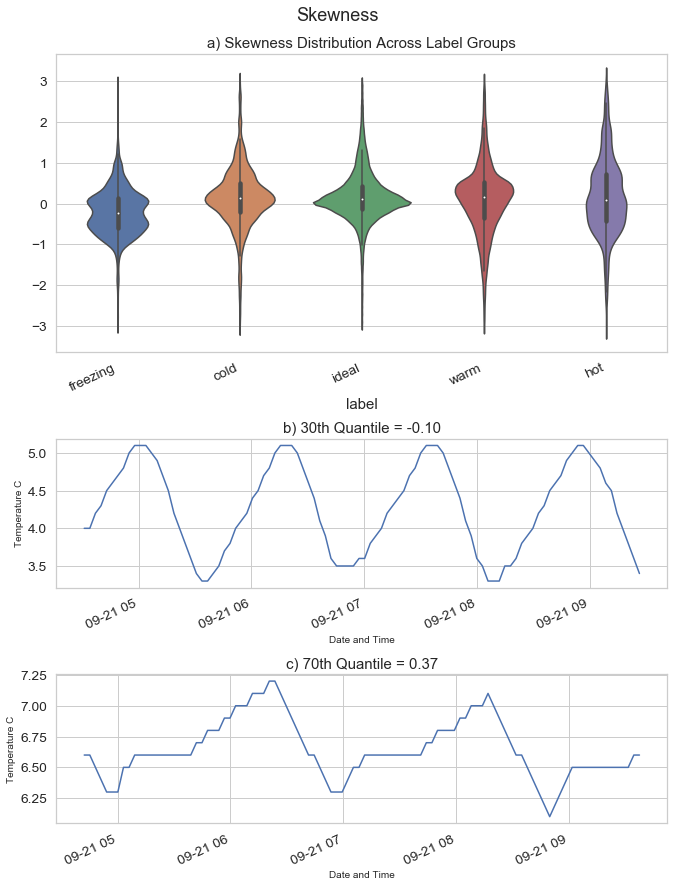

In [144]:
fig,ax1,ax2,ax3 = plot_quantile("temperature__skewness")
ax1.set_title("a) Skewness Distribution Across Label Groups")
#ax1.set_title("a) skewness - 30th Quantile")
#ax2.set_title("b) skewness - 70th Quantile")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=25, ha="right")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=25, ha="right")
ax3.set_xticklabels(ax2.get_xticklabels(), rotation=25, ha="right")
fig.suptitle("Skewness", y=1.02)
fig.savefig(figdir + r'\skewness_v2.png')

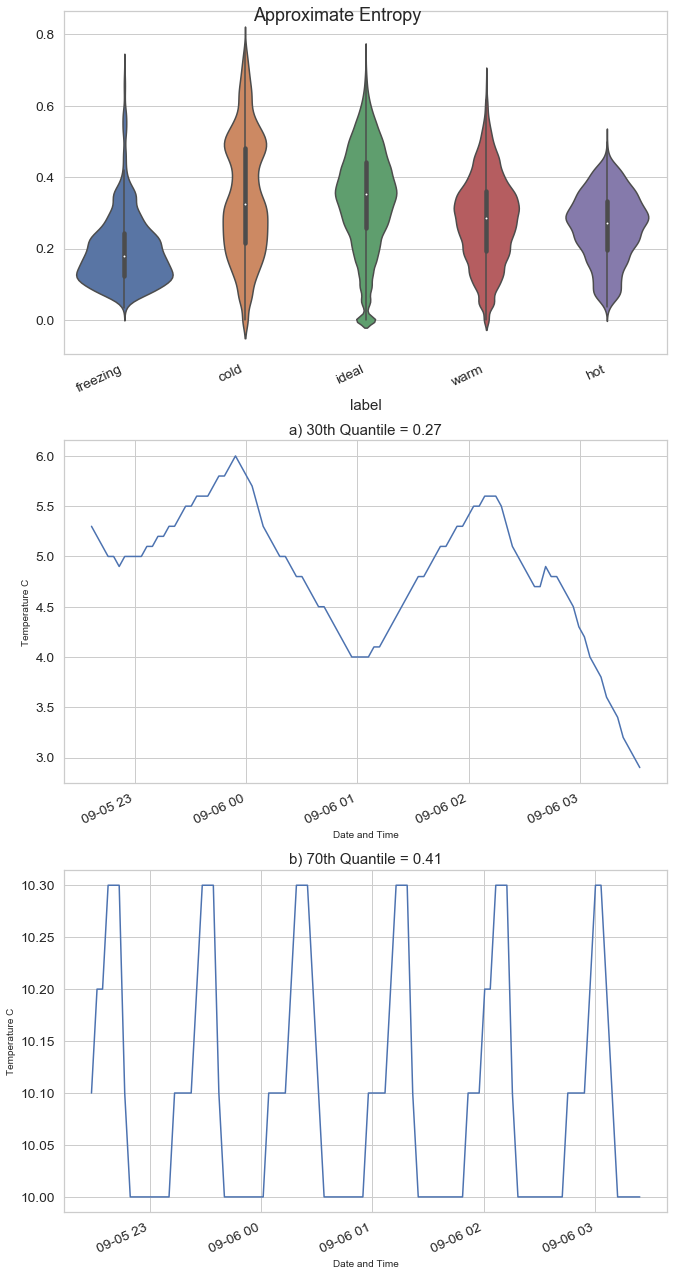

In [116]:
fig,ax1,ax2,ax3 = plot_quantile("temperature__approximate_entropy__m_2__r_0.1")
#ax1.set_title("a) Approximate Entropy m_2 r_0.1 - 30th Quantile")
#ax2.set_title("b) Approximate Entropy m_2 r_0.1 - 70th Quantile")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=25, ha="right")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=25, ha="right")
ax3.set_xticklabels(ax2.get_xticklabels(), rotation=25, ha="right")
fig.suptitle("Approximate Entropy")
fig.savefig(figdir + r'\approximate_entropy__m_2__r_0.1_v2.png')

In [10]:
features["exponential_ar_coefficient"] = 2**(features["temperature__ar_coefficient__coeff_10__k_10"])
features["exponential_ar_coefficient"].describe()

count    486322.000000
mean          0.985226
std           0.102543
min           0.000000
25%           0.927070
50%           0.986393
75%           1.035587
max           7.930985
Name: exponential_ar_coefficient, dtype: float64

In [6]:
features["temperature__ar_coefficient__coeff_10__k_10"].describe()

count    4.863220e+05
mean    -3.762087e+02
std      2.623335e+05
min     -1.829430e+08
25%     -1.092504e-01
50%     -1.976562e-02
75%      5.044808e-02
max      2.987500e+00
Name: temperature__ar_coefficient__coeff_10__k_10, dtype: float64

(0.8, 1.25)

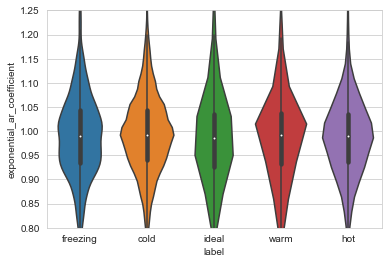

In [20]:
import matplotlib.pyplot as plt
sns.violinplot(x="label",y="exponential_ar_coefficient", data = features,order=["freezing","cold","ideal","warm","hot"])
plt.ylim(0.8,1.25)

In [14]:
import seaborn as sns
fig,ax1,ax2,ax3 = plot_quantile("exponential_ar_coefficient")
#ax1.set_title("a) Arima Coefficient 10 - 30th Quantile")
#ax2.set_title("b) Arima Coefficient 10 - 70th Quantile")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=25, ha="right")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=25, ha="right")
ax3.set_xticklabels(ax2.get_xticklabels(), rotation=25, ha="right")
fig.suptitle("transformed AR Coefficient")
fig.savefig(figdir + r'\ar_coefficient_transformed.png')

NameError: name 'plt' is not defined

In [11]:
fig,ax1,ax2,ax3 = plot_quantile("temperature__ar_coefficient__coeff_10__k_10")
#ax1.set_title("a) Arima Coefficient 10 - 30th Quantile")
#ax2.set_title("b) Arima Coefficient 10 - 70th Quantile")
ax1.set_yscale("log")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=25, ha="right")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=25, ha="right")
ax3.set_xticklabels(ax2.get_xticklabels(), rotation=25, ha="right")
fig.suptitle("AR Coefficient")
fig.savefig(figdir + r'\ar_coefficient__coeff_10__k_10_v2.png')

NameError: name 'df_rolled' is not defined

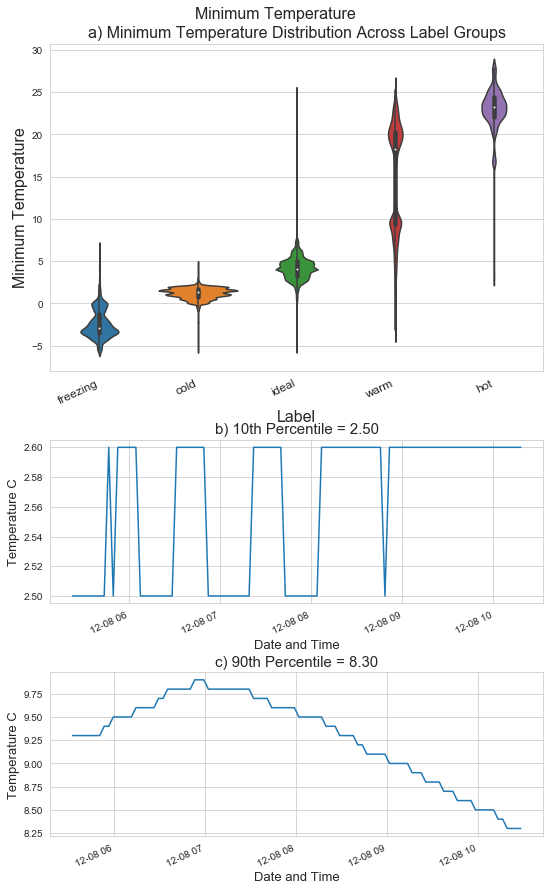

In [69]:
fig,ax1,ax2,ax3 = plot_quantile("temperature__minimum")
ax1.set_title("a) Minimum Temperature Distribution Across Label Groups", fontsize=16)
#ax1.set_title("a) Benford Correlation - 30th Quantile")
#ax2.set_title("b) Benford Correlation - 70th Quantile")
ax1.set_ylabel("Minimum Temperature",fontsize=16)
ax1.set_xlabel("Label",fontsize=16,y=0.02)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=25, ha="right", fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=25, ha="right")
ax3.set_xticklabels(ax2.get_xticklabels(), rotation=25, ha="right")
fig.suptitle("Minimum Temperature", y=1.02,fontsize = 16)
fig.savefig(figdir + r'\minimum_temperature_v2.pdf')